In [140]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from pyslfp import FingerPrint, plot_SHGrid, ResponseFields
import oldsolver.RFmod as RF
import oldsolver.SLmod as SL
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs 
import cartopy.feature as cfeature
import cmocean
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plotting 
def plot_from_shgrid(fun, ax, vmin=None, vmax=None, cmap='cmo.balance_r', shift=180):
    ## Function that organises SHGrid objects and plots them correctly
    ## Might be extended to include plot_kwargs and cbar_kwargs

    if vmin is None and vmax is None:
        maxval = np.max(np.abs(fun.data))
        vmin = -maxval
        vmax = maxval

    field = ax.pcolormesh(fun.lons()-shift,fun.lats(),fun.data, cmap=cmap, vmin=vmin, vmax=vmax)
    
    axins = inset_axes(ax, width="100%",height="5%",loc='lower left',bbox_to_anchor=(0.00, -0.15, 1, 1),bbox_transform=ax.transAxes,borderpad=0)
    cbar = plt.colorbar(field,cax=axins,orientation='horizontal')
    #cbar.set_label(r'[Mass / Unit area]',labelpad=8)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# Aim: to compare fingerprint calculations between the old and new codes

# Preliminaries for the old code
L = 128
Q = RF.sobolev_covariance(L, s=2, mu=0.2)
sl0,ice0 = SL.get_sl_ice_data(L)
C = SL.ocean_function(sl0,ice0)
rhoi = SL.rhoi
rhow = SL.rhow
b = SL.b
g = SL.g

# Preliminaries for the new code
fingerprint = FingerPrint(L, grid='GLQ')
fingerprint.set_background_state_from_ice_ng(version = 6)


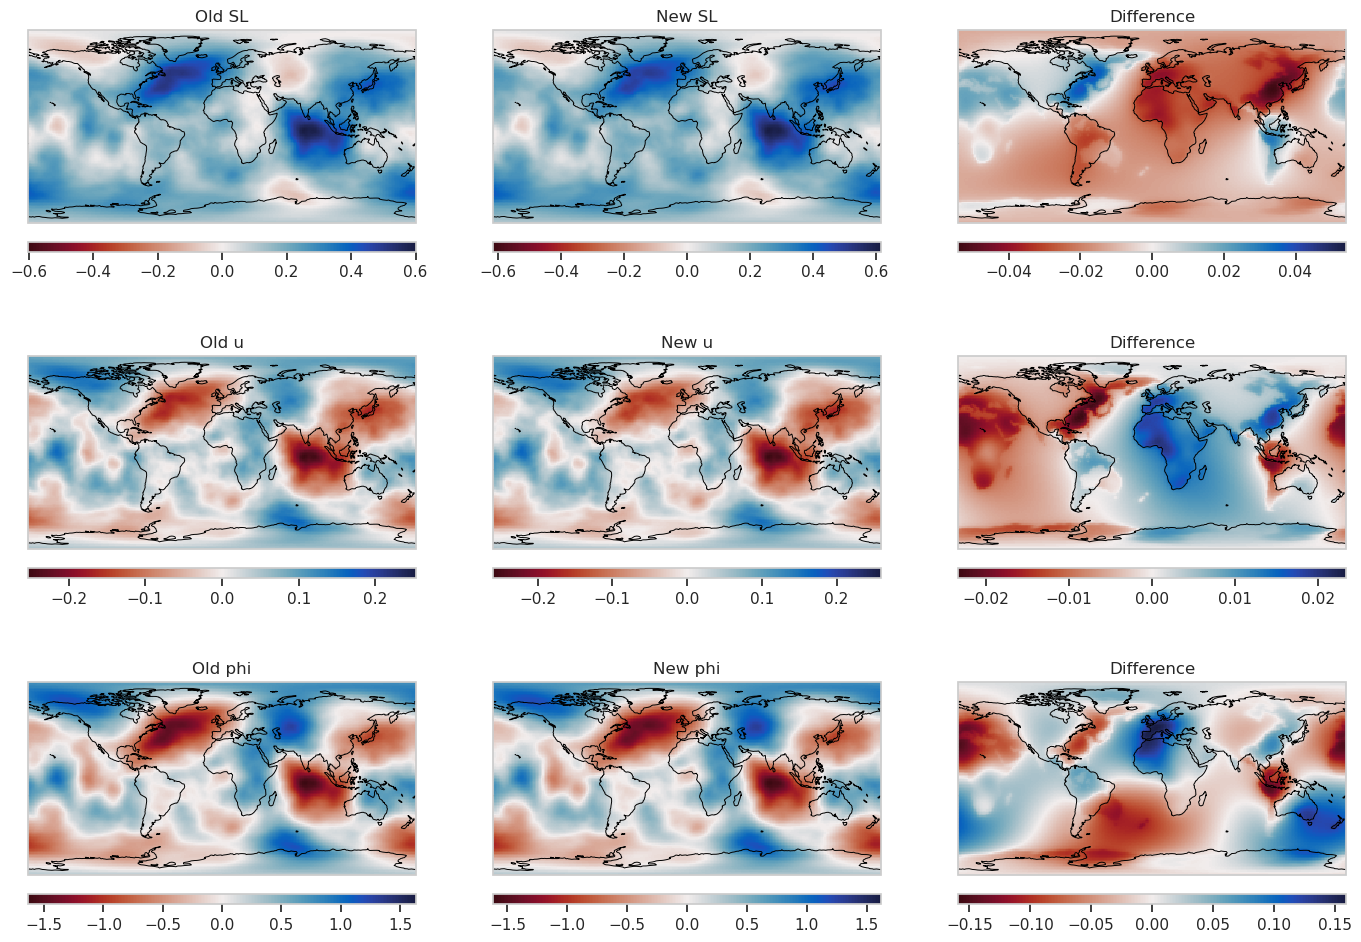

In [96]:
# Create a random load, and calculate the response fields using both codes
zeta = -rhow * RF.random_field(Q)

# Old code
sl, u, phi, om, _ = SL.fingerprint(C, zeta, verbose=False, rotation=True)
old_response = ResponseFields(u, phi, om, sl)

# New code
new_response = fingerprint.solver(zeta, rotational_feedbacks=True)

# Compare the response fields
fig, ax = plt.subplots(3, 3, figsize=(17,12), subplot_kw=dict(projection=crs.PlateCarree()))

# sl
plot_from_shgrid(old_response.sl, ax[0,0])
plot_from_shgrid(new_response.sl, ax[0,1])
plot_from_shgrid(old_response.sl - new_response.sl, ax[0,2])
[a.set_title(t) for a,t in zip(ax[0,:], ['Old SL', 'New SL', 'Difference'])]

# u
plot_from_shgrid(old_response.u, ax[1,0])
plot_from_shgrid(new_response.u, ax[1,1])
plot_from_shgrid(old_response.u - new_response.u, ax[1,2])
[a.set_title(t) for a,t in zip(ax[1,:], ['Old u', 'New u', 'Difference'])]

# phi
plot_from_shgrid(old_response.phi, ax[2,0])
plot_from_shgrid(new_response.phi, ax[2,1])
plot_from_shgrid(old_response.phi - new_response.phi, ax[2,2])
[a.set_title(t) for a,t in zip(ax[2,:], ['Old phi', 'New phi', 'Difference'])]

c = [[a.add_feature(cfeature.COASTLINE, zorder=1, linewidth=0.7) for a in ax[i,:]] for i in range(3)]

(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='GLQ longitude index', ylabel='GLQ latitude index'>)

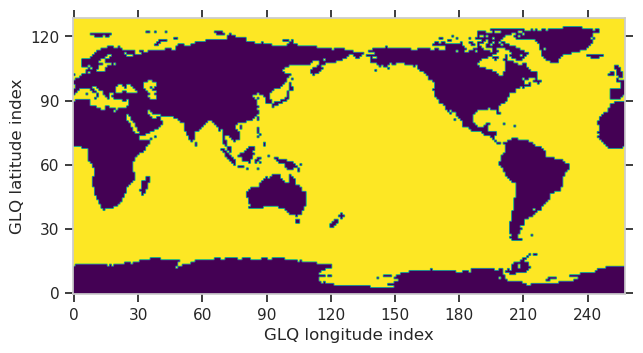

In [93]:
fingerprint.ocean_function.plot()

(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='GLQ longitude index', ylabel='GLQ latitude index'>)

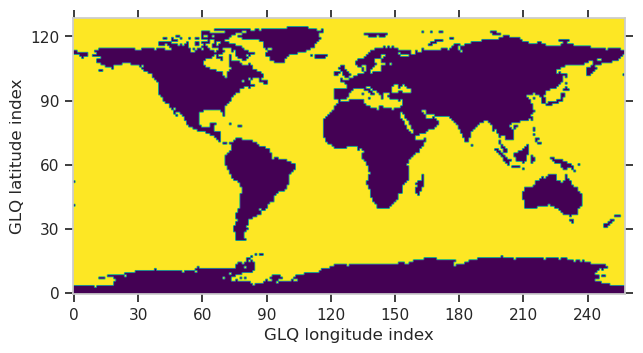

In [94]:
SL.ocean_function(sl0,ice0).plot()

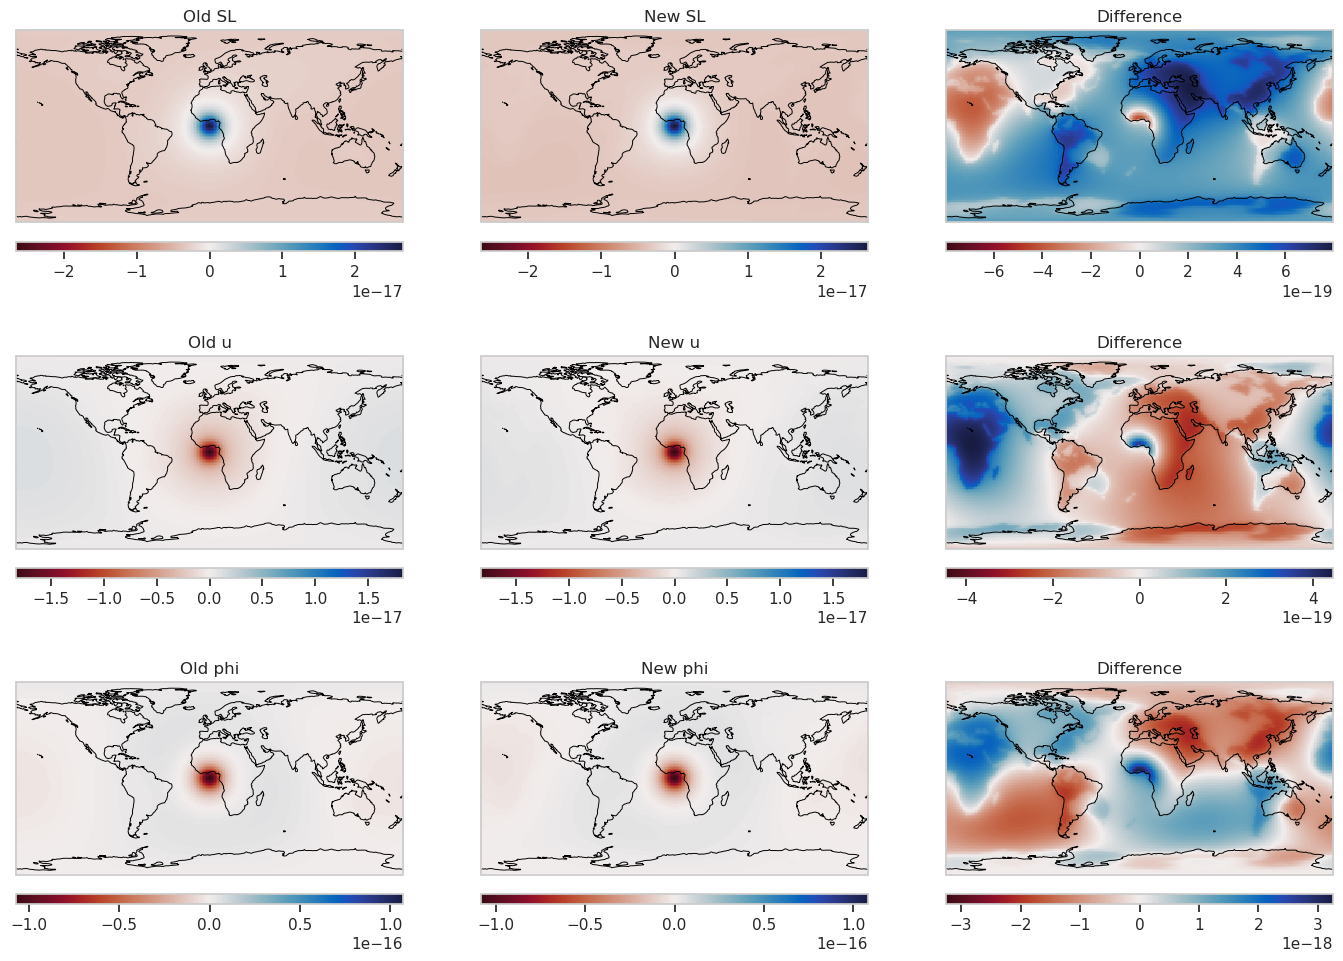

In [95]:
# They do not match because the ocean function in the new code is translated 180 in longitude

# Test using a point load, generated from the old and new codes respectively
delta_zeta_old = SL.point_load(L, np.array([0]), np.array([0]), angle = 10)
delta_zeta_new = fingerprint.point_load(0, 0, delta = 10)

# Redo the plots with these loads
# Old code
sl, u, phi, om, _ = SL.fingerprint(C, delta_zeta_old, verbose=False, rotation=True)
delta_response_old = ResponseFields(u, phi, om, sl)

# New code
delta_response_new = fingerprint.solver(delta_zeta_new, rotational_feedbacks=True)

# Compare the response fields
fig, ax = plt.subplots(3, 3, figsize=(17,12), subplot_kw=dict(projection=crs.PlateCarree()))

# sl
plot_from_shgrid(delta_response_old.sl, ax[0,0])
plot_from_shgrid(delta_response_new.sl, ax[0,1])
plot_from_shgrid(delta_response_old.sl - delta_response_new.sl, ax[0,2])
[a.set_title(t) for a,t in zip(ax[0,:], ['Old SL', 'New SL', 'Difference'])]

# u
plot_from_shgrid(delta_response_old.u, ax[1,0])
plot_from_shgrid(delta_response_new.u, ax[1,1])
plot_from_shgrid(delta_response_old.u - delta_response_new.u, ax[1,2])
[a.set_title(t) for a,t in zip(ax[1,:], ['Old u', 'New u', 'Difference'])]

# phi
plot_from_shgrid(delta_response_old.phi, ax[2,0])
plot_from_shgrid(delta_response_new.phi, ax[2,1])
plot_from_shgrid(delta_response_old.phi - delta_response_new.phi, ax[2,2])
[a.set_title(t) for a,t in zip(ax[2,:], ['Old phi', 'New phi', 'Difference'])]

c = [[a.add_feature(cfeature.COASTLINE, zorder=1, linewidth=0.7) for a in ax[i,:]] for i in range(3)]

In [190]:
# Melt the whole of greenland in both codes, and measure the sea level change at a few places

# Locations (coastal cities)
locations = {'Nuuk': (64.1836, -51.7214),
              'New York': (40.7128, -74.0060),
              'London': (51.5074, -0.1278),
              'Tokyo': (35.6895, 139.6917),
              'Sydney': (-33.8688, 151.2093),
              'Cape Town': (-33.9249, 18.4241),
              'Rio de Janeiro': (-22.9068, -43.1729),
              'Mumbai': (19.0760, 72.8777),}

# Old code
zeta_old = -rhoi * SL.greenland_mask(sl0, ice0, val = 0) * ice0
sl,u,phi,om,psi = SL.fingerprint(C, zeta_old, verbose = False)

# New code
zeta_new = -fingerprint.ice_density * fingerprint.northern_hemisphere_mask(value = 0) * fingerprint.ice_thickness
response = fingerprint.solver(zeta_new)

# Evaluate the sea level change at each location and for each code
sl_measurements_old = {loc: SL.point_evaluation(sl, lat, lon).flatten()[0] for loc, (lat, lon) in locations.items()}
sl_measurements_new = {loc: fingerprint.evaluate_point(response.sl, lat, lon+180) for loc, (lat, lon) in locations.items()}
for loc in locations.keys():
    print(f'--{loc}--')
    print(f'Old code: {sl_measurements_old[loc]:.2f}, New code: {sl_measurements_new[loc]:.2f}, Diff: {100*(sl_measurements_old[loc] - sl_measurements_new[loc])/sl_measurements_old[loc]:.2f}%')

# Compare the overall masses of the loads
print('')
total_mass_old = SL.surface_integral(zeta_old)
total_mass_new = fingerprint.integrate(zeta_new)
print('Total masses of the loads:')
print(f'Old code: {total_mass_old:.2e}, New code: {total_mass_new:.2e}, Diff: {100*(total_mass_old - total_mass_new)/total_mass_old:.2f}%')


--Nuuk--
Old code: -26.58, New code: -26.59, Diff: -0.05%
--New York--
Old code: 3.37, New code: 3.42, Diff: -1.23%
--London--
Old code: 0.93, New code: 1.00, Diff: -7.99%
--Tokyo--
Old code: 9.23, New code: 9.28, Diff: -0.52%
--Sydney--
Old code: 7.59, New code: 7.69, Diff: -1.35%
--Cape Town--
Old code: 9.28, New code: 9.21, Diff: 0.66%
--Rio de Janeiro--
Old code: 9.18, New code: 9.20, Diff: -0.18%
--Mumbai--
Old code: 7.84, New code: 7.95, Diff: -1.31%

Total masses of the loads:
Old code: -2.79e+18, New code: -2.81e+18, Diff: -0.72%


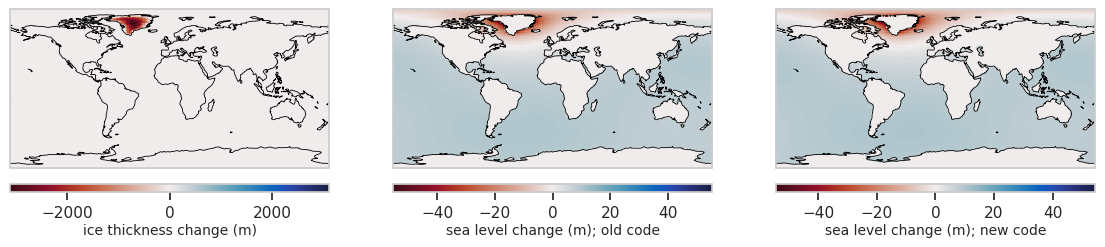

In [192]:
# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(14,12), subplot_kw=dict(projection=crs.PlateCarree()))

oceanmask_old = SL.ocean_mask(sl0, ice0, val = 0)
plot_from_shgrid(zeta_old/SL.rhoi, ax[0])
plot_from_shgrid(sl * oceanmask_old, ax[1])
plot_from_shgrid(response.sl * fingerprint.ocean_mask(value = 0), ax[2], shift = 0)

c = [a.add_feature(cfeature.COASTLINE, zorder=1, linewidth=0.6) for a in ax]
titles = ['ice thickness change (m)', 'sea level change (m); old code', 'sea level change (m); new code']
t = [a.set_title(t, y=-0.45, pad = 4, size=10) for a,t in zip(ax, titles)]